<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#The-main-point" data-toc-modified-id="The-main-point-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>The main point</a></span><ul class="toc-item"><li><span><a href="#A-few-more-details-on-the-objects-that-are-used-here..." data-toc-modified-id="A-few-more-details-on-the-objects-that-are-used-here...-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>A few more details on the objects that are used here...</a></span></li></ul></li><li><span><a href="#Get-the-notes-data" data-toc-modified-id="Get-the-notes-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get the notes data</a></span><ul class="toc-item"><li><span><a href="#The-data-we'll-use" data-toc-modified-id="The-data-we'll-use-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>The data we'll use</a></span></li><li><span><a href="#Extra:-How-tempered-are-we-(how-consistent-is-the-step-size-between-notes)?" data-toc-modified-id="Extra:-How-tempered-are-we-(how-consistent-is-the-step-size-between-notes)?-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Extra: How tempered are we (how consistent is the step size between notes)?</a></span></li></ul></li><li><span><a href="#Color-data" data-toc-modified-id="Color-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Color data</a></span><ul class="toc-item"><li><span><a href="#The-way-I-got-the-color-data" data-toc-modified-id="The-way-I-got-the-color-data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>The way I got the color data</a></span></li></ul></li></ul></div>

# The main point

 I've often seen that “color of musical notes” thing, 
 and I always wondered about it (especially because I’d like to use it as educational support when I teach my (reluctant) 
 daughter music). 
 The mappings I see are not always consistent, but one comes up most often; 
 the one where the red-to-violet range is mapped to the C-to-B range. 
 Now this could just so happen to be correct, but the choice that C as the canonical root note of a scale seems 
 to be arbitrary, whereas red as the first color is a physical reality, leading me to think that:
- The choice of C as the root note was purposely based on the red-to-violet correspondence
- It’s a crock of s**t 
 
Here's look into the numbers…

In [1]:
import requests
import pandas as pd
import numpy as np
import re
from collections import Counter

note_to_abs_note = lambda note: re.compile('[#A-G]+').match(note).group(0)

def get_notes_base_freq():
    url = 'https://pages.mtu.edu/~suits/notefreqs.html'
    r = requests.get(url)
    html = r.content
    _, df = pd.read_html(html)
    df.columns = ['Note', 'Frequency', 'Wavelength']
    df['abs_note'] = list(map(note_to_abs_note, df['Note']))
    df['log2_freq'] = np.log2(df['Frequency'])
    df['log2_base_freq'] = np.mod(df['log2_freq'], 1)  # to get a representative frequency number for a note
    
    # the decimals=2 is what leads to a consistent note->log2_base_freq mapping:
    df['log2_base_freq'] = np.round(df['log2_base_freq'], decimals=2)  
    assert len(Counter(df['log2_base_freq'])) == len(Counter(df['abs_note']))  # assert that we're good!
    
    t = df[['abs_note', 'log2_base_freq']].groupby('abs_note').mean()
    return t.reset_index()

def get_color_base_freq():
    url = 'https://en.wikipedia.org/wiki/Color'
    r = requests.get(url)
    html = r.content
    tables = pd.read_html(html)
    d = tables[2]  # chose number 2 manually (see "the way I got the color data" section)
    d = d[['Color', '(THz)']]
    d = d.iloc[1:8]
    d['(THz)'] = d['(THz)'].astype(float)
    d['Color'] = d['Color'].replace('Violet (visible)', 'Violet')
    t = d['(THz)'] * 1e12  # Tera means 10^12 (10 ** 12 == 1e12)
    d['log2_base_freq'] = np.mod(np.log2(t), 1)
    d['color_freq_THz'] = d['(THz)']
    del d['(THz)']
    return d

notes = get_notes_base_freq()
color = get_color_base_freq()

the_truth_about_it = pd.merge_asof(notes.sort_values('log2_base_freq'), 
                                   color.sort_values('log2_base_freq'), 
                                   on='log2_base_freq')

print(the_truth_about_it.to_string(index=False))

abs_note  log2_base_freq   Color  color_freq_THz
       C            0.03   Green           566.0
      C#            0.11    Cyan           600.0
       D            0.20    Blue           638.0
      D#            0.28    Blue           638.0
       E            0.36  Violet           714.0
       F            0.45  Violet           714.0
      F#            0.53  Violet           714.0
       G            0.61     Red           428.0
      G#            0.70     Red           428.0
       A            0.78     Red           428.0
      A#            0.86  Orange           484.0
       B            0.95  Yellow           517.0


The conclusion is:

It’s a lie. At least the C -> red, D -> Orange, ..., B -> Violet is.

But… It does seem to correspond to an A-based scale! 
That is 
- A -> Red (on the orange side), 
- B -> Yellow, 
- C -> Green, 
- D -> Blue, 
- E -> Blue-Violet, 
- F -> Red-Violet, 
- G -> Red

Which now makes me think that it’s the reason why we call it “A” in the first place...

## A few more details on the objects that are used here...

In [67]:
notes = get_notes_base_freq()
color = get_color_base_freq()

In [68]:
notes

,abs_note,log2_base_freq
0,A,0.781360
1,A#,0.864715
2,B,0.948047
3,C,0.031336
4,C#,0.114675
5,D,0.198003
6,D#,0.281388
7,E,0.364668
8,F,0.448040
9,F#,0.531334


In [69]:
color

,Color,log2_base_freq,color_freq_THz
1,Red,0.604604,428.0
2,Orange,0.782000,484.0
3,Yellow,0.877158,517.0
4,Green,0.007795,566.0
5,Cyan,0.091956,600.0
6,Blue,0.180550,638.0
7,Violet,0.342917,714.0


In [70]:
pd.merge_asof(notes.sort_values('log2_base_freq'), 
              color.sort_values('log2_base_freq'), 
              on='log2_base_freq')

,abs_note,log2_base_freq,Color,color_freq_THz
0,C,0.031336,Green,566.0
1,C#,0.114675,Cyan,600.0
2,D,0.198003,Blue,638.0
3,D#,0.281388,Blue,638.0
4,E,0.364668,Violet,714.0
5,F,0.448040,Violet,714.0
6,F#,0.531334,Violet,714.0
7,G,0.614702,Red,428.0
8,G#,0.698041,Red,428.0
9,A,0.781360,Red,428.0


In [71]:
pd.merge_asof(color.sort_values('log2_base_freq'), 
              notes.sort_values('log2_base_freq'), 
              on='log2_base_freq')

,Color,log2_base_freq,color_freq_THz,abs_note
0,Green,0.007795,566.0,NaN
1,Cyan,0.091956,600.0,C
2,Blue,0.180550,638.0,C#
3,Violet,0.342917,714.0,D#
4,Red,0.604604,428.0,F#
5,Orange,0.782000,484.0,A
6,Yellow,0.877158,517.0,A#


In [ ]:
color.replace()

# Get the notes data

In [27]:
url = 'https://pages.mtu.edu/~suits/notefreqs.html'
r = requests.get(url)
html = r.content
_, df = pd.read_html(html)
print(df.shape)
df.columns = ['Note', 'Frequency', 'Wavelength']
df['abs_note'] = list(map(note_to_abs_note, df['Note']))
df['log2_freq'] = np.log2(df['Frequency'])

# the decimals=2 is what leads to a consistent note->log2_base_freq mapping:
df['log2_base_freq'] = np.round(np.mod(df['log2_freq'], 1), decimals=2)  

df.head()

(108, 3)


,Note,Frequency,Wavelength,abs_note,log2_freq,log2_base_freq
0,C0,16.35,2109.89,C,4.031219,0.03
1,C#0/Db0,17.32,1991.47,C#,4.114367,0.11
2,D0,18.35,1879.69,D,4.197708,0.20
3,D#0/Eb0,19.45,1774.20,D#,4.281698,0.28
4,E0,20.60,1674.62,E,4.364572,0.36


In [56]:
Counter(df['abs_note'])

Counter({'C': 9,
         'C#': 9,
         'D': 9,
         'D#': 9,
         'E': 9,
         'F': 9,
         'F#': 9,
         'G': 9,
         'G#': 9,
         'A': 9,
         'A#': 9,
         'B': 9})

In [65]:
Counter(df['log2_base_freq'])

Counter({0.03: 9,
         0.11: 9,
         0.2: 9,
         0.28: 9,
         0.36: 9,
         0.45: 9,
         0.53: 9,
         0.61: 9,
         0.7: 9,
         0.78: 9,
         0.86: 9,
         0.95: 9})

In [66]:
assert len(Counter(df['log2_base_freq'])) == len(Counter(df['abs_note']))

## The data we'll use

In [74]:
t = df[['abs_note', 'log2_base_freq']].groupby('abs_note').mean()
t = t.to_dict()['log2_base_freq']
# somehow, we lost the purity of the digits, so re-rounding:
log2_base_of_note = {k: round(v, 2) for k, v in t.items()}  
log2_base_of_note

{'A': 0.78,
 'A#': 0.86,
 'B': 0.95,
 'C': 0.03,
 'C#': 0.11,
 'D': 0.2,
 'D#': 0.28,
 'E': 0.36,
 'F': 0.45,
 'F#': 0.53,
 'G': 0.61,
 'G#': 0.7}

## Extra: How tempered are we (how consistent is the step size between notes)?

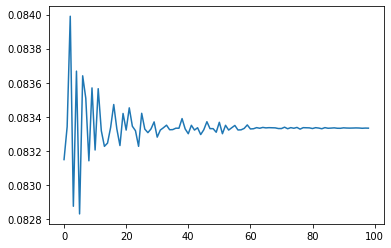

In [64]:
t = np.diff(np.mod(df['log2_freq'], 1))
plt.plot(t[abs(t) < 0.5])

# Color data

In [22]:
url = 'https://en.wikipedia.org/wiki/Color'
r = requests.get(url)
html = r.content
tables = pd.read_html(html)
d = tables[2]  # chose number 2 manually (see "the way I got the color data" section)
d = d[['Color', '(THz)']]
d = d.iloc[1:8]
d['(THz)'] = d['(THz)'].astype(float)
d['Color'] = d['Color'].replace('Violet (visible)', 'Violet')
t = d['(THz)'] * 1e12  # Tera means 10^12 (10 ** 12 == 1e12)
d['log2_base_freq'] = np.mod(np.log2(t), 1)
d

,Color,(THz),log2_base_freq
1,Red,428.0,0.604604
2,Orange,484.0,0.782000
3,Yellow,517.0,0.877158
4,Green,566.0,0.007795
5,Cyan,600.0,0.091956
6,Blue,638.0,0.180550
7,Violet (visible),714.0,0.342917


## The way I got the color data

In [3]:
url = 'https://en.wikipedia.org/wiki/Color'
r = requests.get(url)
html = r.content

In [4]:
tables = pd.read_html(html)
len(tables)

11

We have 11 tables there, let's flip through them

Run this:

In [5]:
from itertools import cycle
it = cycle(enumerate(tables))

Then run the following as many times as you want...

The number that is printed is the index of t that has the table you're seeing

In [116]:
i, d = next(it)
print(i)
d

5


,0,1
0,Color space,Color model additive subtractive Color mixing ...
1,Color scheme,Color tool Monochromatic colors Complementary ...
2,Color theory,Chromaticity diagram Color solid Color wheel C...


Two tables show promise

In [6]:
tables[1]

,Color,Color.1,Wavelengthinterval,Frequencyinterval
0,NaN,Red,~ 700–635 nm,~ 430–480 THz
1,NaN,Orange,~ 635–590 nm,~ 480–510 THz
2,NaN,Yellow,~ 590–560 nm,~ 510–540 THz
3,NaN,Green,~ 560–520 nm,~ 540–580 THz
4,NaN,Cyan,~ 520–490 nm,~ 580–610 THz
5,NaN,Blue,~ 490–450 nm,~ 610–670 THz
6,NaN,Violet,~ 450–400 nm,~ 670–750 THz


In [7]:
tables[2]

,Color,(nm),(THz),(μm−1),(eV),(kJ mol−1)
0,Infrared,>1000,<300,<1.00,<1.24,<120
1,Red,700,428,1.43,1.77,171
2,Orange,620,484,1.61,2.00,193
3,Yellow,580,517,1.72,2.14,206
4,Green,530,566,1.89,2.34,226
5,Cyan,500,600,NaN,NaN,NaN
6,Blue,470,638,2.13,2.64,254
7,Violet (visible),420,714,2.38,2.95,285
8,Near ultraviolet,300,1000,3.33,4.15,400
9,Far ultraviolet,<200,>1500,>5.00,>6.20,>598


Interesting that the numbers aren't completely consistent -- the numbers in the second aren't consistently in the middle of the ranges of the first table.

Anyway, we'll use the second table, because there's ready too use numbers, not ranges

In [17]:
d = tables[2]
d = d[['Color', '(THz)']]
d = d.iloc[1:8]
d['(THz)'] = d['(THz)'].astype(float)
d

,Color,(THz)
1,Red,428.0
2,Orange,484.0
3,Yellow,517.0
4,Green,566.0
5,Cyan,600.0
6,Blue,638.0
7,Violet (visible),714.0


In [20]:
t = d['(THz)'] * 1e12  # Tera means 10^12 (10 ** 12 == 1e12)
d['log2_base_freq'] = np.mod(np.log2(t), 1)
d

,Color,(THz),log2_base_freq
1,Red,428.0,0.604604
2,Orange,484.0,0.782000
3,Yellow,517.0,0.877158
4,Green,566.0,0.007795
5,Cyan,600.0,0.091956
6,Blue,638.0,0.180550
7,Violet (visible),714.0,0.342917
